# Calibrating Astronomical Images
<img src='images/logo.png' width="300" height="300" align='right'>
This tutorial will step you through the basic procedure to calibrate a raw astronomical image taken with the Thacher Observatory's science camera. You will need to have a local version of the Thacher Astronomy repositories and have those repositories along your python path for this notebook to work. 

Before we get into the code, here is a quick primer on calibrations for any charge coupled device (or CCD) camera and why they are necessary. The text has been lifted heavily from [Howell (2006, chapter 4)](http://adsabs.harvard.edu/abs/2006hca..book.....H).

### Bias:
Every camera offsets the zero level so that the A/D converter never outputs a negative number. This offset is different for every camera and every camera setting (for those cameras with changeable settings). This "bias" value is not necessarily constant for every pixel and must be measured so that it can be subtracted from the raw science frame.

The bias image has an exposure time of zero seconds. The shutter remains closed and the CCD is simply read out. The purpose of a bias or zero frame is to allow the user to determine the underlying noise level within each data frame. The bias value in a CCD image is usually a low spatial frequency variation throughout the array, caused by the CCD on-chip amplifiers. This variation should remain constant with time. The rms value of the bias level is the CCD read noise. A bias frame contains both the DC offset level (overscan) and the variations on that level. The nature of the bias variations for a given CCD are usually column-wise variations, but may also have small row-wise components as well. Thus, a 2-D, pixel-by-pixel subtraction is often required. A single bias frame will not sample these variations well in a statistical fashion, so an average bias image of 10 or more single bias frames is recommended.

### Dark:
Photons are emitted from every body with a non-zero temperature (on the Kelvin scale). Therefore everything emits light, even your camera. These thermal photons can cause a signal in a sensitive CCD camera and therefore the rate at which this occurs needs to be accounted for in a fully calibrated image. 

CCD dark frames are images taken with the shutter closed but for some time period, usually equal to that of your target frames. That is, if one is planning to dark correct a 45 second exposure, a 45 second dark frame would typically be obtained. Longer dark frames can often be avoided using the assumption that the dark current increases linearly with time and a simple scaling can be applied. However, this is not always true. Dark frames are a method by which the thermal noise (dark current) in a CCD can be measured. They also can give you information about bad or "hot" pixels that exist as well as provide an estimate of the rate of cosmic ray strikes at your observing site. Observatory class CCD cameras are usually cooled with liquid nitrogen to temperatures at which the dark current is essentially zero. Many of these systems therefore do not require the use of dark exposure CCD frames in the calibration process. Thermoelectrically cooled systems are typically not cooled to low enough temperatures such that one may ignore the dark current, but they are getting better. In addition, these less expensive models often have poor temperature stability allowing the dark current to wander a bit with time. Multiple darks averaged together are the best way to produce the final dark calibration frame. Note that the bias is also present in dark frames. To get an accurate measure of the dark current, the bias must be subtracted.

### Flat:
Not every pixel in a CCD camera responds to the sky in the exact same way. There are many reasons for this. For one, not every pixel is created equally, so there may be some intrinsic sensitivity difference from pixel to pixel. However, the CCD may be obscured slightly by the optics of the telescope, or by dust on the camera or filters. Therefore this pixel-to-pixel variation must also be accounted for.

Flat field exposures are used to correct for pixel-to-pixel variations in the CCD response as well as any nonuniform illumination of the detector itself. Flat fields expose the CCD to light from either a dome screen, the twilight sky, the nighttime sky, or a projector lamp in an attempt to provide a high signal-to-noise ratio (SNR) uniformly illuminated calibration image. For narrow-band imaging, flats are very helpful in removing fringing, which may occur in object frames. Flat field calibration frames are needed for each color, wavelength region, or different instrumental setup used in which object frames are to be taken. A good flat should remain constant to about l%, with 2% or larger changes being indicators of a possible problem. As with the other calibration frames, at least 5 or more flat fields should be taken and averaged to produce the final flat used for image calibration.

As always, we begin by importing some very useful packages.

In [1]:
# Numpy and matplotlib, you will get used to these packages.
import numpy as np
import matplotlib.pyplot as plt

# Astropy utilities
from astropy.io import fits
from astropy.wcs import WCS

# Some other packages that are real useful
import glob
from tqdm.notebook import trange, tqdm

# Here we change some global plotting parameters.
import matplotlib as mpl
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['image.cmap'] = 'Greys_r'

# run the %matplotlib magic command to enable inline plotting in the current Notebook
%matplotlib inline

First we shall load our "bias" frame

In [2]:
bfiles = glob.glob('data/calibration/Bias*fts')
bct = len(bfiles)
print('There were '+str(bct)+' bias files read')
print('The file names are:')
for bf in bfiles:
    print(bf)

There were 30 bias files read
The file names are:
data/calibration/Bias-20170521at142642_-30-1X1-000.fts
data/calibration/Bias-20170521at142621_-30-1X1-000.fts
data/calibration/Bias-20170521at142555_-30-1X1-000.fts
data/calibration/Bias-20170521at142702_-30-1X1-000.fts
data/calibration/Bias-20170521at142345_-30-1X1-000.fts
data/calibration/Bias-20170521at142614_-30-1X1-000.fts
data/calibration/Bias-20170521at142527_-30-1X1-000.fts
data/calibration/Bias-20170521at142514_-30-1X1-000.fts
data/calibration/Bias-20170521at142628_-30-1X1-000.fts
data/calibration/Bias-20170521at142454_-30-1X1-000.fts
data/calibration/Bias-20170521at142413_-30-1X1-000.fts
data/calibration/Bias-20170521at142352_-30-1X1-000.fts
data/calibration/Bias-20170521at142521_-30-1X1-000.fts
data/calibration/Bias-20170521at142426_-30-1X1-000.fts
data/calibration/Bias-20170521at142655_-30-1X1-000.fts
data/calibration/Bias-20170521at142548_-30-1X1-000.fts
data/calibration/Bias-20170521at142440_-30-1X1-000.fts
data/calibratio

These bias frames can be stacked, and the median value of each pixel is taken from the stack of bias frames to determine the "master" bias frame. 

In [3]:
# First get a test image to find the dimensions
image = fits.getdata(bfiles[0])
ysz,xsz = image.shape
print('Image dimensions are '+str(ysz)+' by '+str(xsz))
stack = np.zeros((bct,ysz,xsz))

Image dimensions are 2048 by 2048


In [5]:
pbar = tqdm(desc = 'Loading bias images', total = bct, unit = 'file')
for i in range(bct):
    image = fits.getdata(bfiles[i])
    stack[i,:,:] = image
    pbar.update(1)
pbar.close()
print('Finding median pixel values...')
bias = np.median(stack,axis=0)
print('Done')

Loading bias images:   0%|          | 0/30 [00:00<?, ?file/s]

Finding median pixel values...
Done


Let's now take a look at the bias frame

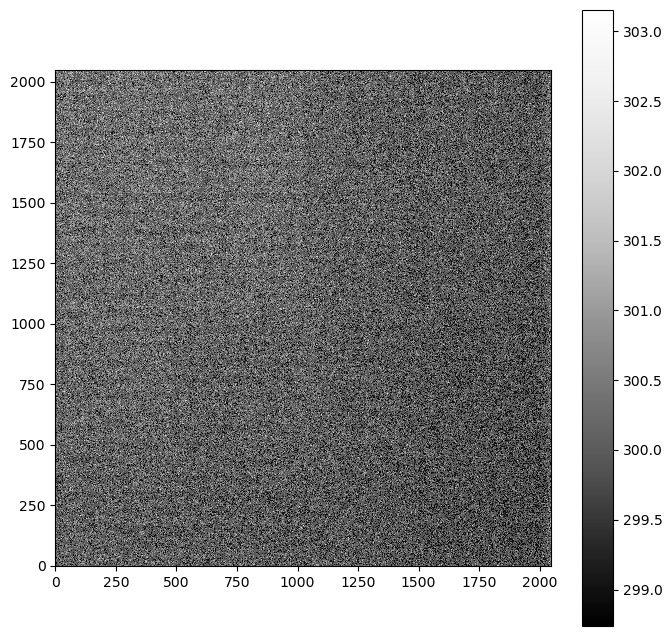

In [6]:
plt.figure(1,figsize=(8,8))
plt.imshow(bias,vmin=np.median(bias)-2*np.std(bias),vmax=np.median(bias)+5*np.std(bias))
plt.colorbar()

Next we create a master dark frame. Notice that we need the master bias to create a master dark because each dark frame has the bias in it. So, to get an accurate measurement of the "dark current," we need to subtract the bias off of each dark frame.

In [7]:
dfiles = glob.glob('data/calibration/Dark*fts')
dct = len(dfiles)
print('There were '+str(dct)+' dark files read')
print('The file names are:')
for df in dfiles:
    print(df)

There were 30 dark files read
The file names are:
data/calibration/Dark-20170521at140313_-30-1X1-300.fts
data/calibration/Dark-20170521at121022_-30-1X1-300.fts
data/calibration/Dark-20170521at120515_-30-1X1-300.fts
data/calibration/Dark-20170521at122546_-30-1X1-300.fts
data/calibration/Dark-20170521at124617_-30-1X1-300.fts
data/calibration/Dark-20170521at141836_-30-1X1-300.fts
data/calibration/Dark-20170521at114945_-30-1X1-300.fts
data/calibration/Dark-20170521at134751_-30-1X1-300.fts
data/calibration/Dark-20170521at131156_-30-1X1-300.fts
data/calibration/Dark-20170521at123054_-30-1X1-300.fts
data/calibration/Dark-20170521at135806_-30-1X1-300.fts
data/calibration/Dark-20170521at133228_-30-1X1-300.fts
data/calibration/Dark-20170521at124109_-30-1X1-300.fts
data/calibration/Dark-20170521at120007_-30-1X1-300.fts
data/calibration/Dark-20170521at121530_-30-1X1-300.fts
data/calibration/Dark-20170521at123601_-30-1X1-300.fts
data/calibration/Dark-20170521at131704_-30-1X1-300.fts
data/calibratio

In [8]:
# Image dimensions of the dark frame (better be the same as the bias!)
image = fits.getdata(dfiles[0])
ysz,xsz = image.shape
print('Image dimensions are '+str(ysz)+' by '+str(xsz))
stack = np.zeros((dct,ysz,xsz))

Image dimensions are 2048 by 2048


Notice that we make the dark frame such that the units are counts per second!

In [9]:
pbar = tqdm(desc = 'Loading bias images', total = dct, unit = 'file')
for i in range(dct):
    image,header = fits.getdata(dfiles[i],header=True)
    stack[i,:,:] = (image - bias)/header['EXPTIME']
    pbar.update(1)
pbar.close()
print('Finding median pixel values...')
dark = np.median(stack,axis=0)
print('Done')

Loading bias images:   0%|          | 0/30 [00:00<?, ?file/s]

Finding median pixel values...
Done


Now take a look at the dark frame

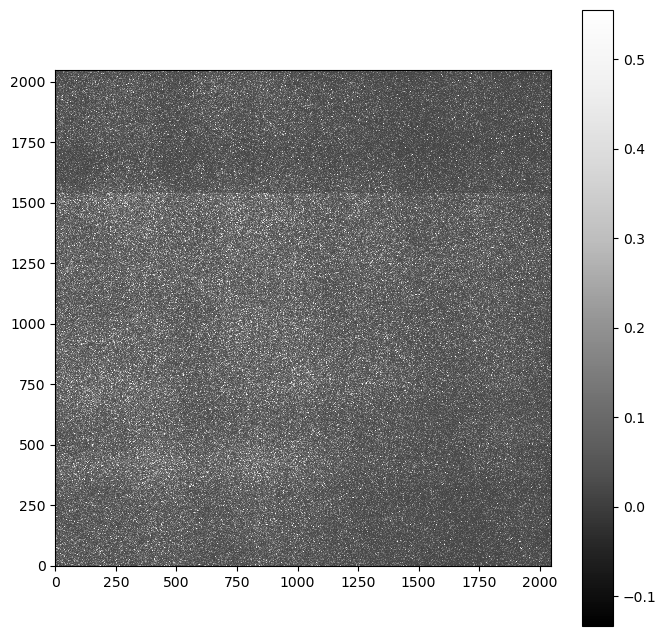

In [10]:
plt.figure(1,figsize=(8,8))
plt.imshow(dark,vmin=np.median(dark)-2*np.std(dark),vmax=np.median(dark)+5*np.std(dark))
plt.colorbar()

For our last calibration, we create a master flat field. Since these images were taken with a finite integration time, we need to use both our bias and our dark frames. Only with these can the true pixel-to-pixel sensitivities be measured.

In [11]:
ffiles = glob.glob('data/calibration/M51*flat*fit')
fct = len(ffiles)
print('There were '+str(fct)+' flat files read')
print('The file names are:')
for ff in ffiles:
    print(ff)

There were 31 flat files read
The file names are:
data/calibration/M51-0045_flat.fit
data/calibration/M51-0071_flat.fit
data/calibration/M51-0070_flat.fit
data/calibration/M51-0052_flat.fit
data/calibration/M51-0053_flat.fit
data/calibration/M51-0066_flat.fit
data/calibration/M51-0067_flat.fit
data/calibration/M51-0058_flat.fit
data/calibration/M51-0059_flat.fit
data/calibration/M51-0055_flat.fit
data/calibration/M51-0054_flat.fit
data/calibration/M51-0061_flat.fit
data/calibration/M51-0060_flat.fit
data/calibration/M51-0048_flat.fit
data/calibration/M51-0049_flat.fit
data/calibration/M51-0065_flat.fit
data/calibration/M51-0064_flat.fit
data/calibration/M51-0051_flat.fit
data/calibration/M51-0050_flat.fit
data/calibration/M51-0072_flat.fit
data/calibration/M51-0073_flat.fit
data/calibration/M51-0046_flat.fit
data/calibration/M51-0047_flat.fit
data/calibration/M51-0075_flat.fit
data/calibration/M51-0074_flat.fit
data/calibration/M51-0062_flat.fit
data/calibration/M51-0063_flat.fit
data/

In [12]:
# Image dimensions of the flat frames (better be the same as both the bias and the dark!)
image = fits.getdata(ffiles[0])
ysz,xsz = image.shape
print('Image dimensions are '+str(ysz)+' by '+str(xsz))
stack = np.zeros((fct,ysz,xsz))

Image dimensions are 2048 by 2048


Notice how the flat is "normalized" so that the median value in the frame is 1.0 (or 100% sensitivity)

In [13]:
pbar = tqdm(desc = 'Loading bias images', total = fct, unit = 'file')
for i in range(fct):
    image,header = fits.getdata(ffiles[i],header=True)
    stack[i,:,:] = image - bias - dark*header['EXPTIME']
    pbar.update(1)
pbar.close()
print('Finding median pixel values...')
flat = np.median(stack,axis=0)
flat /= np.median(flat)
print('Done')

Loading bias images:   0%|          | 0/31 [00:00<?, ?file/s]

Finding median pixel values...
Done


Now take a look at the flat frame

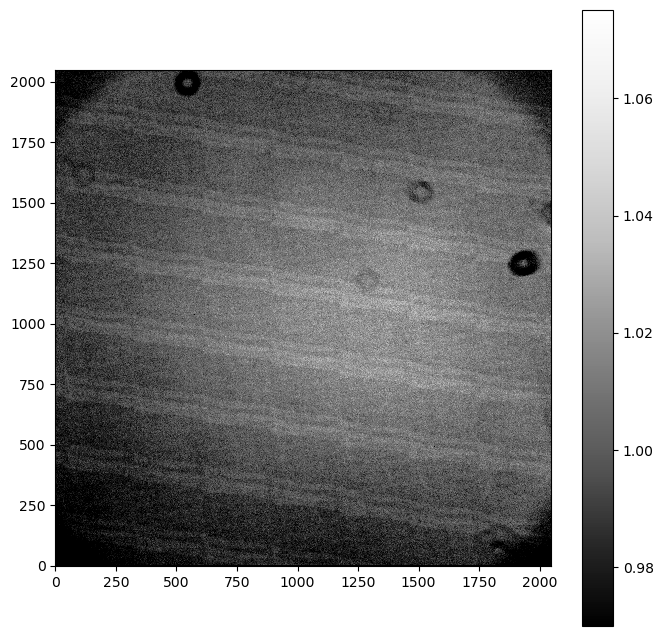

In [14]:
plt.figure(1,figsize=(8,8))
plt.imshow(flat,vmin=np.median(flat)-2*np.std(flat),vmax=np.median(flat)+5*np.std(flat))
plt.colorbar()

Now we are ready to look at our target image. Later, we will learn how to stack many images together to obtain a higher fidelity image. But for now we will look at a single image in our stack.

In [15]:
tfiles = glob.glob('data/calibration/M51*solved.fits')
tct = len(tfiles)
print('There were '+str(tct)+' target files read')
print('The file names are:')
for tf in tfiles:
    print(tf)

There were 12 target files read
The file names are:
data/calibration/M51-20170521at074803-Temp-30-Bin1-Exp300-V_solved.fits
data/calibration/M51-20170521at052739-Temp-30-Bin1-Exp300-V_solved.fits
data/calibration/M51-20170521at072244-Temp-30-Bin1-Exp300-V_solved.fits
data/calibration/M51-20170521at050140-Temp-30-Bin1-Exp300-V_solved.fits
data/calibration/M51-20170521at061549-Temp-30-Bin1-Exp300-V_solved.fits
data/calibration/M51-20170521at055309-Temp-30-Bin1-Exp300-V_solved.fits
data/calibration/M51-20170521at051452-Temp-30-Bin1-Exp300-V_solved.fits
data/calibration/M51-20170521at073524-Temp-30-Bin1-Exp300-V_solved.fits
data/calibration/M51-20170521at064302-Temp-30-Bin1-Exp300-V_solved.fits
data/calibration/M51-20170521at065546-Temp-30-Bin1-Exp300-V_solved.fits
data/calibration/M51-20170521at062945-Temp-30-Bin1-Exp300-V_solved.fits
data/calibration/M51-20170521at054024-Temp-30-Bin1-Exp300-V_solved.fits


Let's choose the middle file in this sequence to calibrate and view.

In [16]:
target,header = fits.getdata(tfiles[tct//2],header=True)

Let's take a look at the raw image. You may be able to see some of the artifacts from either the bias, dark or flat.

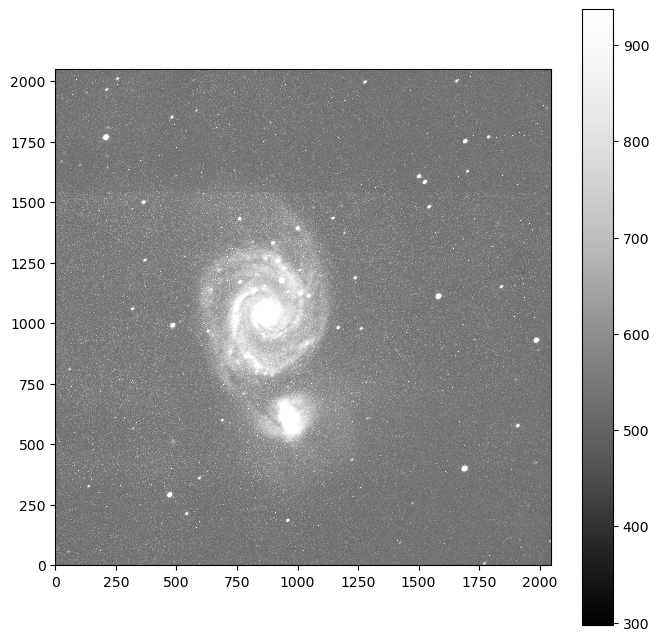

In [17]:
plt.figure(1,figsize=(8,8))
im = target
plt.imshow(im,vmin=np.median(im)-2*np.std(im),vmax=np.median(im)+3*np.std(im))
plt.colorbar()

Well, we can see that it is M51, but there are clearly some calibration issues. Let's first take the bias out and look at the partially calibrated image.

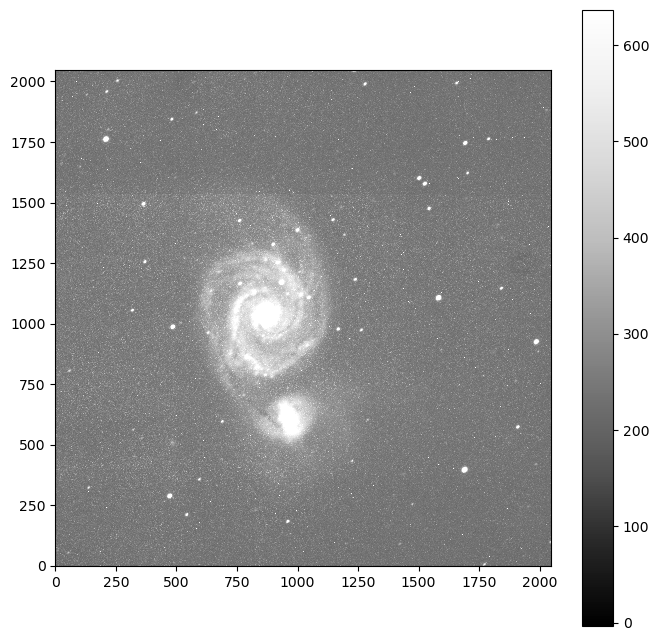

In [18]:
plt.figure(1,figsize=(8,8))
im = target-bias
plt.imshow(im,vmin=np.median(im)-2*np.std(im),vmax=np.median(im)+3*np.std(im))
plt.colorbar()

It doesn't really look any better, but the pixel values are sure different.

Next, let's subtract the dark current AND the bias. Here is a subtlety worth noting. The dark current is given in counts **per second**. Therefore, to properly calibrate the image we need to subtract the dark current frame times the exposure time.

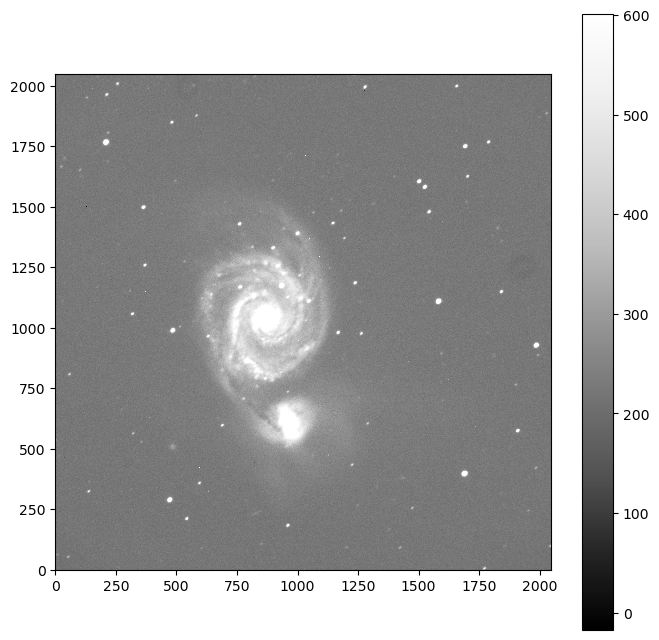

In [19]:
plt.figure(1,figsize=(8,8))
im = target-bias-dark*header['EXPTIME']
plt.imshow(im,vmin=np.median(im)-2*np.std(im),vmax=np.median(im)+3*np.std(im))
plt.colorbar()

Much better! However, we can still see some artifacts like the dust that is obscuring the frame around pixel (1900,1250). This is what the flat field is for. Let's now take a look at a fully calibrated image.

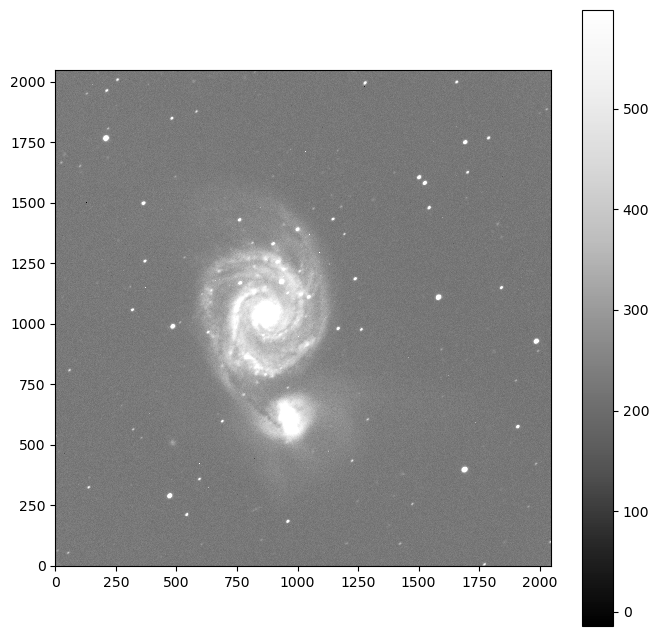

In [20]:
cal = (target-bias-dark*header['EXPTIME'])/flat
plt.figure(1,figsize=(8,8))
plt.imshow(cal,vmin=np.median(cal)-2*np.std(cal),vmax=np.median(cal)+3*np.std(cal))
plt.colorbar()

Fantastic! Now let's write out our final image to disk.

In [ ]:
fits.writeto('data/calibration/M51_single_cal.fits',cal,header,overwrite=True)

So, now we have a fully calibrated image! Let's not stop there. Below are a sequence of commands that allow us to visualize our final image in a professional way, with grid lines of Right Ascension and Declination. The code is annotated so that you may understand how it works and can modify it to your liking.

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


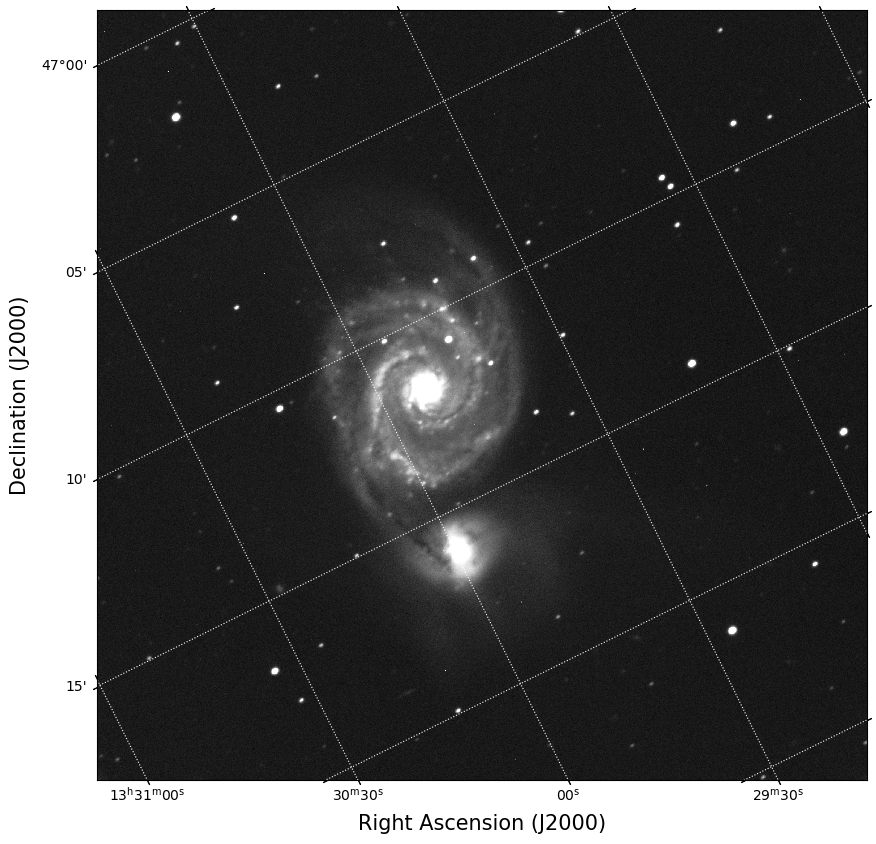

In [21]:
# Set the stretch limits 
siglo=0.5
sighi=5
clipmin = np.median(cal)-siglo*np.std(cal)
clipmax = np.median(cal)+sighi*np.std(cal)

# Read in the orientation of the image
wcs = WCS(header)

# Make a plot
plt.figure(figsize=(14,10))
plt.subplot(projection=wcs)
plt.imshow(cal, vmin=clipmin, vmax=clipmax, origin='lower')
plt.grid(color='white', ls='dotted')
plt.xlabel('Right Ascension (J2000)',size=15)
plt.ylabel('Declination (J2000)',size=15)
plt.savefig('M51_calibrated.png',dpi=300,bbox_inches='tight')

Beautiful!!!

## Excercise
1. Now that you have a beautiful image, figure out how to save the image to your disk and submit your final image as a jpeg file as evidence that you know how to do it!